# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Final Project Milestone 3


**Harvard University**<br/>
**Spring 2025**<br/>
**Team**: Amar Boparai, Andrew Lobo, Conrad Kaminski, Xiaoxuan Zhang, Xuanthe Nguyen<br/>
**Canvas Project Group**: 31

<hr style="height:2pt">

### Data Description & Addressing Feedback

Our feedback from MS2 asked how we plan to evaluate the fairness of our model using the identity columns (e.g., `female`, `black`, `muslim`, etc.). These columns indicate whether a comment references that specific identity. These identities will not be used during training, but we will use it in our post-training fairness evaluation. We will include group-wise performance metrics, assessing how the model performs within each identity subgroup including: true positive rate; false positive rate; and precision, recall, and F1-scores. This will allow us to see if the model is disproportionately flagging non-toxic comments as toxic for certain groups. Then, we can also do subgroup fairness metrics like subgroup AUC for distinguishing toxic vs. non-toxic comments within the subgroup; BPSN AUC (background positive, subgroup negative) for comparing non-toxic subgroup comments vs. toxic background comments; and BNSP AUC (background negative, subgroup positive) for comparing toxic subgroup comments vs. non-toxic background comments.

Once again, we are using the Jigsaw Unintended Bias in Toxicity Classification dataset from [Kaggle](https://www.kaggle.com/datasets/julian3833/jigsaw-multilingual-toxic-comment-classification), which contains ~1.9 million online comments labeled for various forms of toxicity. In MS2, after cleaning and subsetting, our final dataset includes comment_text as input and seven binary toxicity labels as outputs (toxic, insult, threat). The data is highly imbalanced, with most toxicity categories appearing in less than 10% of the samples.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import seaborn as sns
import csv
import os
%matplotlib inline

### Loading Data

In [2]:
df_cleaned = pd.read_csv("data/cleaned_ms2_data.csv")
df_cleaned.head()

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,59848,"This is so cool. It's like, 'would you want yo...",0,0,0,0,0,0,0
1,59849,Thank you!! This would make my life a lot less...,0,0,0,0,0,0,0
2,59852,This is such an urgent design problem; kudos t...,0,0,0,0,0,0,0
3,59855,Is this something I'll be able to install on m...,0,0,0,0,0,0,0
4,59856,haha you guys are a bunch of losers.,1,0,0,0,1,0,0


In [3]:
print("Shape:", df_cleaned.shape)

Shape: (1902191, 9)


In [4]:
print("Data types:\n", df_cleaned.dtypes)

Data types:
 id                  int64
comment_text       object
toxic               int64
severe_toxicity     int64
obscene             int64
identity_attack     int64
insult              int64
threat              int64
sexual_explicit     int64
dtype: object


In [5]:
print("Descriptive statistics:\n", df_cleaned.describe())

Descriptive statistics:
                  id         toxic  severe_toxicity       obscene  \
count  1.902191e+06  1.902191e+06     1.902191e+06  1.902191e+06   
mean   3.912770e+06  7.996621e-02     6.834224e-06  5.333849e-03   
std    2.497349e+06  2.712409e-01     2.614227e-03  7.283819e-02   
min    5.984800e+04  0.000000e+00     0.000000e+00  0.000000e+00   
25%    8.273535e+05  0.000000e+00     0.000000e+00  0.000000e+00   
50%    5.282204e+06  0.000000e+00     0.000000e+00  0.000000e+00   
75%    5.862734e+06  0.000000e+00     0.000000e+00  0.000000e+00   
max    7.194639e+06  1.000000e+00     1.000000e+00  1.000000e+00   

       identity_attack        insult        threat  sexual_explicit  
count     1.902191e+06  1.902191e+06  1.902191e+06     1.902191e+06  
mean      7.410928e-03  5.904244e-02  2.366219e-03     2.589645e-03  
std       8.576718e-02  2.357042e-01  4.858622e-02     5.082264e-02  
min       0.000000e+00  0.000000e+00  0.000000e+00     0.000000e+00  
25%       0.

From this, we can numerically see the class imbalance. Let's look at it graphically.

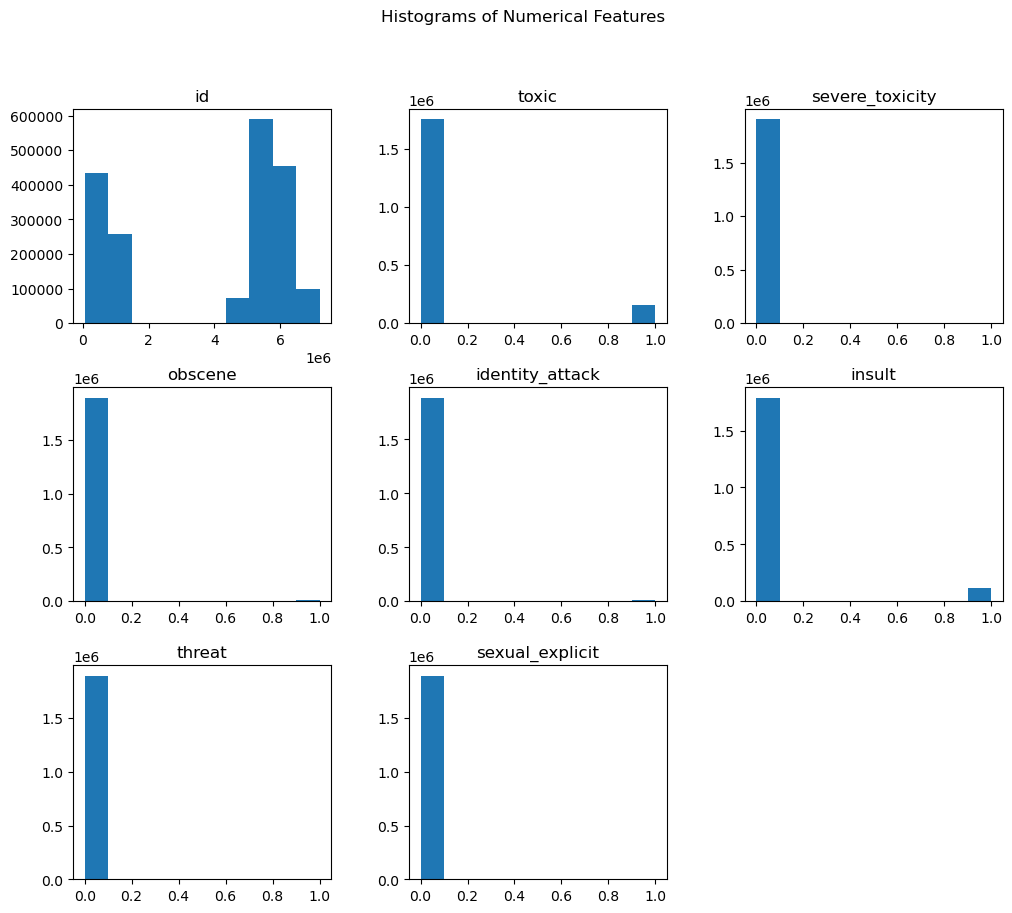

In [6]:
df_cleaned.hist(bins=10, figsize=(12, 10), grid=False)
plt.suptitle("Histograms of Numerical Features")
plt.show()


We can again see that there is a large class imbalance. To mitigate this, we will include `severe_toxic` in the `toxic` category. 

In [11]:
df_cleaned['toxic'] = df_cleaned['toxic'] | df_cleaned['severe_toxicity']
df_cleaned = df_cleaned.drop(columns=['severe_toxicity'])


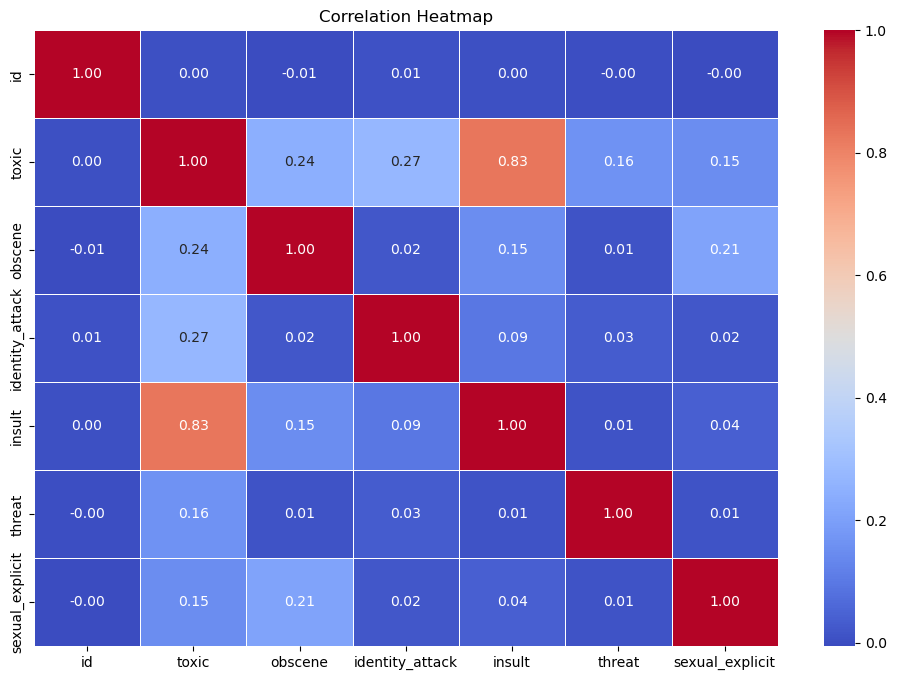

In [12]:
# correlation matrix and heatmap for numeric columns
corr = df_cleaned.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


### EDA

To understand our data better, we do an initial missingness analysis of all columns.

In [10]:
missing_summary = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({'Missing Count': missing_summary, 'Missing %': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False)
missing_df


NameError: name 'df' is not defined

We notice that the  missinginess is most present in the identity columns. This is because only a subset of the comments have been labeled with identity attributes.

These identity columns will be used only to evaluate the fairness of the model after training, not to train the model itself. In other words, we can train the model on the non-identity inputs and evaluate the bias of the model later using the identity columns. 

Before addressing the missingness of the variables we plan to include, we'll subset the data to include only what we will input to our model.

### Subsetting Dataset

Here, we subset to only include relevant columns. We remove identity columns, as mentioned above, and we also remove columns related to metadata (such as *id, publication_id, article_id,* etc) because they are not useful for toxicity prediction.

Other columns (*likes, funny, sad, wow*) may tell us about user sentiment but are not immediately useful for toxicity prediction.

We subset to a dataset with just the input and outputs. The input to our model is *comment_text*, and the outputs we will predict are *toxic, severe_toxicity, obscene, identity_attack, insult, threat, sexual_explicit*

In [ ]:
cols = ['id', 'comment_text', 'toxic', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']
df_subset = df[cols]

### Missingness

We now examine the missingness of the subsetted dataset

In [ ]:
missing_summary = df_subset.isnull().sum()
missing_percent = (df_subset.isnull().sum() / len(df_subset)) * 100

missing_df = pd.DataFrame({'Missing Count': missing_summary, 'Missing %': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False)
missing_df

,Missing Count,Missing %
comment_text,3,0.000158


In [ ]:
df_missing_comment_text = df[df['comment_text'].isna()]
df_missing_comment_text.head()

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
513346,872115,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,163140,approved,5,0,0,9,1,0.0,0,4
1010795,5353666,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,340316,approved,0,0,0,0,0,0.0,4,4
1512317,5971919,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,378393,approved,0,0,0,1,0,0.0,4,4


It looks like there is no missing data outside of 3 observations where there is no comment_text. Since the dataset is so large, we can drop these three observations.

In [ ]:
len(df_subset)

1902194

In [ ]:
df_cleaned = df_subset.dropna(subset=['comment_text'])

In [ ]:
len(df_cleaned)

1902191

### Examining Imbalance

In [ ]:
label_cols = ['toxic', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']

# Convert all to numeric
for col in label_cols:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# From *Kaggle*: If >0.5 --> 1; If <0.5 --> 0
for col in label_cols:
    df_cleaned[col] = df_cleaned[col].apply(lambda x: 1 if x >= 0.5 else 0)

# Print
for col in label_cols:
    print(f"\n{col.upper()} distribution:")
    print(df_cleaned[col].value_counts())


/var/folders/wy/q726k0jd1xl8xd907nhbgz5w0000gn/T/ipykernel_40406/2954108152.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
/var/folders/wy/q726k0jd1xl8xd907nhbgz5w0000gn/T/ipykernel_40406/2954108152.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].apply(lambda x: 1 if x >= 0.5 else 0)



TOXIC distribution:
toxic
0    1750080
1     152111
Name: count, dtype: int64

SEVERE_TOXICITY distribution:
severe_toxicity
0    1902178
1         13
Name: count, dtype: int64

OBSCENE distribution:
obscene
0    1892045
1      10146
Name: count, dtype: int64

IDENTITY_ATTACK distribution:
identity_attack
0    1888094
1      14097
Name: count, dtype: int64

INSULT distribution:
insult
0    1789881
1     112310
Name: count, dtype: int64

THREAT distribution:
threat
0    1897690
1       4501
Name: count, dtype: int64

SEXUAL_EXPLICIT distribution:
sexual_explicit
0    1897265
1       4926
Name: count, dtype: int64


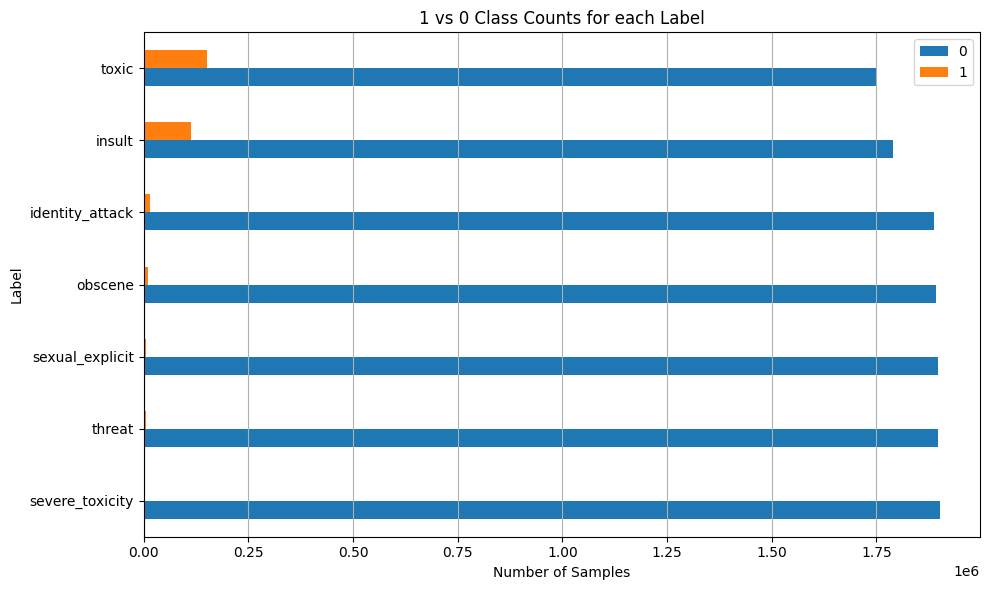

In [ ]:
## AI Assistance for graphing here - ChatGPT showed us to make a dataframe and transpose it
labels_for_graphing = ['toxic', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']

label_distributions = {
    col: df_cleaned[col].value_counts() for col in labels_for_graphing
}

dist_df = pd.DataFrame(label_distributions).T
dist_df.columns = ['0', '1']
dist_df = dist_df.sort_values('1')

# plot
dist_df.plot(kind='barh', stacked=False, figsize=(10, 6))
plt.title("1 vs 0 Class Counts for each Label")
plt.xlabel("Number of Samples")
plt.grid(axis='x')
plt.ylabel("Label")
plt.tight_layout()


plt.show()

Here, we see very high levels of imbalance in our cleaned dataframe. This isn't great because that means a model could just predict '0' and be correct 97% of the time in most cases. 

We aim to address these imbalances using resampling methods:

One resampling method we might consider is **oversampling the minority class**. While this may work for *toxic* and *insult*, it is unlikely to be a good method for the more extreme cases of imbalances seen in other output variables. We could also **undersample the majority class**; however, this would significantly reduce the training data we have. We are unlikely to use this approach. We will not use **SMOTE** because we are dealing with text data.

(AI Assitance for this part:) We can also use **class weights**, which basically tells the model to pay more attention to the minority class because it's underrepresented.

One last strategy we will consider is combining the some of the outputs. For example, there are only 13 observations that are observed as *severe_toxicity*. We could combine all toxicity metrics into one binary variable.

### Feature Scaling

Feature scaling is not necessary for our dataset since we are dealing with raw text data and using BERT/GPT models. Furthermore, our target labels are all float values between 0 and 1 and do not require scaling either. 

### Final Dataset

In [ ]:
df_cleaned.head()

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,59848,"This is so cool. It's like, 'would you want yo...",0,0,0,0,0,0,0
1,59849,Thank you!! This would make my life a lot less...,0,0,0,0,0,0,0
2,59852,This is such an urgent design problem; kudos t...,0,0,0,0,0,0,0
3,59855,Is this something I'll be able to install on m...,0,0,0,0,0,0,0
4,59856,haha you guys are a bunch of losers.,1,0,0,0,1,0,0


Here are the first 5 observations of our cleaned dataset, which includes the input *comment_text* and several output features all between 0 and 1. 

In this milestone, we focused on understanding our data and subsetting our dataset to only include useful variables for model training. We discovered extreme levels of imbalance and discussed several ways to address them. In our next milestone, we will experiment with various methods to address this imbalance.